### import the dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchdiffeq import odeint

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")


### Load raw dataset

In [2]:
df = pd.read_csv(DATA_PATH)

# pick raw RRI columns (prefix 'r_')
feature_cols = [c for c in df.columns if c.startswith("r_")]
meta_cols = ["patient_id", "record_id", "label", "label_str", "orig_len"]

assert len(feature_cols) > 0, "No r_ columns found in CSV"

# Extract features
X = df[feature_cols].values.astype(np.float32)

# Keep labels as float first (avoid invalid int cast)
y_raw = df["label"].values

# Drop rows where features or labels are invalid
mask_good = np.isfinite(X).all(axis=1) & np.isfinite(y_raw) & (y_raw >= 0)

# Apply mask
X = X[mask_good]
y = y_raw[mask_good].astype(int)
record_ids = df["record_id"].values[mask_good]

# Print stats
print("Unique labels:", np.unique(y))
print("Loaded raw samples:", X.shape, "class counts:", np.bincount(y))


Unique labels: [0 1 2]
Loaded raw samples: (14204, 50) class counts: [4750 4707 4747]


In [3]:
X_temp, X_test, y_temp, y_test, rid_temp, rid_test = train_test_split(
    X, y, record_ids, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

X_train, X_val, y_train, y_val, rid_train, rid_val = train_test_split(
    X_temp, y_temp, rid_temp, test_size=0.2, stratify=y_temp, random_state=RANDOM_SEED
)

print("Splits -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# Standardize using training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
record_ids_test = rid_test


Splits -> train: (9090, 50) val: (2273, 50) test: (2841, 50)


### Define Model

In [4]:
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )

    def forward(self, t, x):
        return self.net(x)

class NODEModel(nn.Module):
    def __init__(self, dim, num_classes):
        super(NODEModel, self).__init__()
        self.odefunc = ODEFunc(dim)
        self.classifier = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: (batch, features) — treat as initial state
        t = torch.tensor([0.0, 1.0], dtype=x.dtype, device=x.device)
        out = odeint(self.odefunc, x, t)[-1]
        return self.classifier(out)

### Load model

In [5]:
# path to your model
model_path = os.path.join("..", "Three_Class_Models", "saved_models", "NODE_raw_best.pth")
input_dim = X_test.shape[1]

# instantiate model (make sure to import or define your model class)
model = NODEModel(dim=input_dim, num_classes=3)  # adjust args as needed
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()


NODEModel(
  (odefunc): ODEFunc(
    (net): Sequential(
      (0): Linear(in_features=50, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=50, bias=True)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=50, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
  )
)

### Load test dataset

In [6]:
test_dataset = TensorDataset(
    torch.from_numpy(X_test.astype(np.float32)),
    torch.from_numpy(y_test.astype(np.int64))
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Get probabilities from the model

In [7]:
all_probs = []
all_trues = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = model.to(device)

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = best_model(xb)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_trues.append(yb.numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_trues = np.concatenate(all_trues, axis=0)

# Probability of SR, pre-AF, AF
prob_SR = all_probs[:, 0]  # assuming class 0 is SR
prob_preAF = all_probs[:, 1]
prob_AF = all_probs[:, 2]


### Compute probability of danger

In [8]:
prob_danger = 1 - prob_SR


### Sweep for suitable threshold

Threshold: 0.00 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.02 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.04 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.06 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.08 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.10 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.12 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.14 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.16 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.18 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.20 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.22 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.24 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.26 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.28 | F1: 0.7992 | Acc: 0.6656 | Pos Pred: 2841
Threshold: 0.30 | F1: 0.7994 | Acc: 0.6660 | Pos Pred: 2840
Threshold: 0.32 | F1: 0.8001 | Acc: 0.66

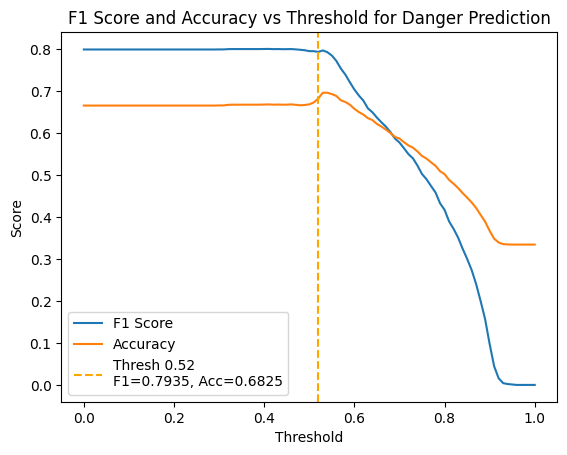

At threshold 0.52: F1 = 0.7935, Accuracy = 0.6825


In [14]:
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

# Sweep thresholds and print metrics
for thresh in np.arange(0, 1.01, 0.02):
    pred_danger = (prob_danger >= thresh).astype(int)
    y_true_danger = (all_trues != 0).astype(int)
    f1 = f1_score(y_true_danger, pred_danger)
    acc = accuracy_score(y_true_danger, pred_danger)
    print(f"Threshold: {thresh:.2f} | F1: {f1:.4f} | Acc: {acc:.4f} | Pos Pred: {pred_danger.sum()}")

# Prepare thresholds for plotting
f1s = []
accs = []
thresholds = np.linspace(0, 1, 101)
for thresh in thresholds:
    pred_danger = (prob_danger >= thresh).astype(int)
    y_true_danger = (all_trues != 0).astype(int)
    f1s.append(f1_score(y_true_danger, pred_danger))
    accs.append(accuracy_score(y_true_danger, pred_danger))

plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, accs, label="Accuracy")

# Plot vertical line at 0.52 and display F1/Acc at that threshold
thresh_line = 0.52
pred_danger_52 = (prob_danger >= thresh_line).astype(int)
y_true_danger = (all_trues != 0).astype(int)
f1_52 = f1_score(y_true_danger, pred_danger_52)
acc_52 = accuracy_score(y_true_danger, pred_danger_52)
plt.axvline(thresh_line, color='orange', linestyle='--', label=f"Thresh 0.52\nF1={f1_52:.4f}, Acc={acc_52:.4f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("F1 Score and Accuracy vs Threshold for Danger Prediction")
plt.legend()
plt.show()

print(f"At threshold 0.52: F1 = {f1_52:.4f}, Accuracy = {acc_52:.4f}")

### Compute Mean Predicted Time Horizon (MPTH)

In [ ]:
import numpy as np
import pandas as pd

# combine your test info and predictions into one DataFrame
test_df = pd.DataFrame({
    "record_id": record_ids_test,
    "y_true": all_trues,
    "P_danger": prob_danger
})

best_thresh = 0.52
window_duration_sec = 30 

results = []

for rid, group in test_df.groupby("record_id"):
    group = group.reset_index(drop=True)
    af_indices = group.index[group["y_true"] == 2].tolist()

    if not af_indices:
        continue  # no AF event in this record

    af_onset_idx = af_indices[0]
    pre_af_windows = group.loc[:af_onset_idx - 1]

    if pre_af_windows.empty:
        continue

    danger_windows = pre_af_windows[pre_af_windows["P_danger"] >= best_thresh]
    if danger_windows.empty:
        continue

    first_alert_idx = danger_windows.index[-1]  # latest danger before AF onset
    window_diff = af_onset_idx - first_alert_idx
    time_horizon_sec = window_diff * window_duration_sec
    results.append(time_horizon_sec)

if results:
    mean_time_horizon = np.mean(results)
    print(f"Mean Predicted Time Horizon: {mean_time_horizon:.2f} seconds "
          f"({mean_time_horizon/60:.2f} minutes)")
else:
    print("No early danger predictions found before AF onset.")


Mean Predicted Time Horizon: 34.07 seconds (0.57 minutes)
